In [1]:
import numpy as np
import phate
import leidenalg
import scprep
import seaborn as sns
import pandas as pd
import scanpy
import matplotlib.pyplot as plt
import magic
from sklearn.preprocessing import scale
import gspa

In [ ]:
adata = scanpy.read_h5ad('./data/skin_processed_human_name.h5ad')
adata.obs['samples'] = [x[:-2] for x in adata.obs.sample_labels]
adata.var_names = adata.var.symbol

In [ ]:
hvgs = np.array(adata[:, adata.var.hvg].var.index)

In [ ]:
phate_op = phate.PHATE(random_state=42, knn=40, decay=10, use_pygsp=True)
phate_op.fit(adata.obsm['X_PCA'])

In [175]:
G = phate_op.graph

In [176]:
data = adata.to_df().loc[:, ~adata.to_df().columns.duplicated()]

In [177]:
magic_op = magic.MAGIC()
magic_op.graph = G
data_magic = magic_op.transform(data, genes=hvgs)

/gpfs/gibbs/project/krishnaswamy_smita/av622/conda_envs/gspa/lib/python3.8/site-packages/magic/magic.py:541: UserWarning: Running MAGIC.transform on different data to that which was used for MAGIC.fit may not produce sensible output, unless it comes from the same manifold.
  warnings.warn(


Calculating imputation...
Calculated imputation in 269.23 seconds.


## CCC

In [7]:
ligands_reduced = np.load('./results/ligand_embedding.npy')
receptors_reduced = np.load('./results/receptor_embedding.npy')

In [8]:
embedding = np.hstack((ligands_reduced[:, :5], receptors_reduced[:, :5])) 

In [9]:
pair_phate_op = phate.PHATE(random_state=42)
pair_phate = pair_phate_op.fit_transform(embedding)

Calculating PHATE...
  Running PHATE on 361 observations and 10 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculating affinities...
  Calculated graph and diffusion operator in 0.01 seconds.
  Calculating optimal t...
    Automatically selected t = 20
  Calculated optimal t in 0.05 seconds.
  Calculating diffusion potential...
  Calculating metric MDS...
  Calculated metric MDS in 0.14 seconds.
Calculated PHATE in 0.22 seconds.


In [78]:
pair_clusters = np.array(leidenalg.find_partition(pair_phate_op.graph.to_igraph(), 
                                                  leidenalg.ModularityVertexPartition,
                                                  seed=0).membership)

In [18]:
signaling_pathways_hvgs = pd.read_csv('results/LR_signaling_clusters.csv', index_col=0)
signaling_pathways_hvgs['clusters'] = pair_clusters
signaling_pathways_hvgs.to_csv('results/LR_signaling_clusters.csv')

## Proportion per condition

In [10]:
signaling_pathways_hvgs = pd.read_csv('results/LR_signaling_clusters.csv', index_col=0)

<Axes: xlabel='Ligand-Receptor PHATE1', ylabel='Ligand-Receptor PHATE2'>

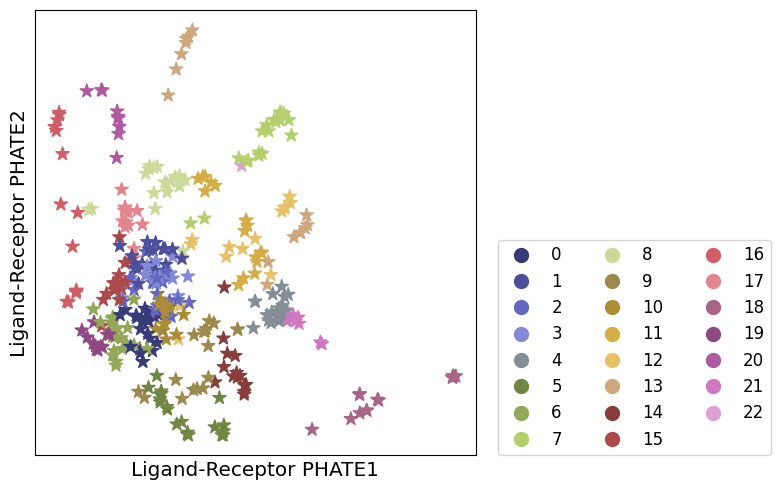

In [14]:
scprep.plot.scatter2d(pair_phate, signaling_pathways_hvgs['clusters'], legend_loc=(1.05,0), ticks=None,
                      figsize=(8,5), dpi=200, marker='*', s=100, cmap=sns.color_palette('tab20b')[:20], discrete=True,
                     label_prefix='Ligand-Receptor PHATE', filename='figures/ligand_receptor_phate.png')

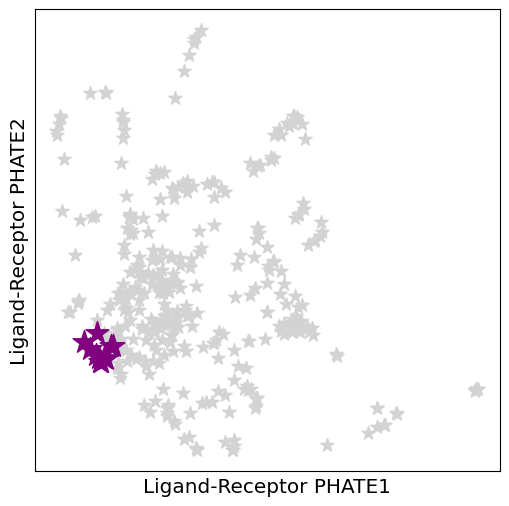

In [33]:
fig, ax = plt.subplots(figsize=(6,6))
scprep.plot.scatter2d(pair_phate, c='lightgray', legend_loc=(1.05,0), ticks=None, dpi=200, marker='*', s=100, ax=ax)
scprep.plot.scatter2d(pair_phate, c='purple', legend_loc=(1.05,0), ticks=None, ax=ax, dpi=200, marker='*', s=300,
                      mask=signaling_pathways_hvgs['clusters'] == 19, discrete=True,
                     label_prefix='Ligand-Receptor PHATE')
fig.savefig('figures/ligand_receptor_phate_cluster_19.png', dpi=500)

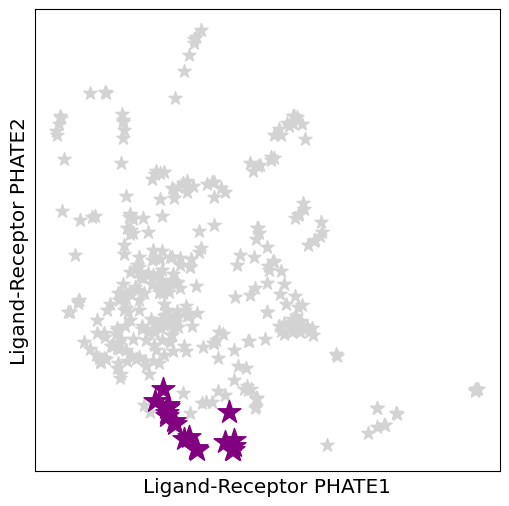

In [34]:
fig, ax = plt.subplots(figsize=(6,6))
scprep.plot.scatter2d(pair_phate, c='lightgray', legend_loc=(1.05,0), ticks=None, dpi=200, marker='*', s=100, ax=ax)
scprep.plot.scatter2d(pair_phate, c='purple', legend_loc=(1.05,0), ticks=None, ax=ax, dpi=200, marker='*', s=300,
                      mask=signaling_pathways_hvgs['clusters'] == 5, discrete=True,
                     label_prefix='Ligand-Receptor PHATE')
fig.savefig('figures/ligand_receptor_phate_cluster_5.png', dpi=500)

In [109]:
cmap={'NO_AG': 'lightgray', 'AG':'red', 'AG_CPI':'blue'}

In [110]:
adata = adata[:, ~adata.var.index.duplicated()]

In [111]:
for module in range(signaling_pathways_hvgs['clusters'].max() + 1):
    ligand_gene_list = signaling_pathways_hvgs[(signaling_pathways_hvgs['clusters'] == module)]['ligand'].values
    #ligand_gene_list = adata.var[adata.var['symbol'].isin(ligand_gene_list)].index
    receptor_gene_list = signaling_pathways_hvgs[(signaling_pathways_hvgs['clusters'] == module)]['receptor'].values
    #receptor_gene_list = adata.var[adata.var['symbol'].isin(receptor_gene_list)].index
    
    scanpy.tl.score_genes(adata, gene_list=ligand_gene_list,
                          random_state=0, score_name=f'GM_{module}_ligand_score',
                          gene_pool=hvgs, n_bins=int(len(hvgs) * 0.25), use_raw=False)
    
    scanpy.tl.score_genes(adata, gene_list=receptor_gene_list,
                      random_state=0, score_name=f'GM_{module}_receptor_score',
                      gene_pool=hvgs, n_bins=int(len(hvgs) * 0.25), use_raw=False)

/gpfs/gibbs/project/krishnaswamy_smita/av622/conda_envs/gspa/lib/python3.8/site-packages/scanpy/tools/_score_genes.py:175: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[score_name] = pd.Series(


In [ ]:
for c in range(signaling_pathways_hvgs['clusters'].max() + 1):
    lig_df = 100* adata.obs['samples'][adata.obs[f'GM_{c}_ligand_score'] > 0.0].value_counts() / adata.obs['samples'].value_counts()
    lig_df = lig_df.loc[['NO_AG', 'AG', 'AG_CPI']]

    rec_df = 100* adata.obs['samples'][adata.obs[f'GM_{c}_receptor_score'] > 0.0].value_counts() / adata.obs['samples'].value_counts()
    rec_df = rec_df.loc[['NO_AG', 'AG', 'AG_CPI']]
    
    df = pd.concat((lig_df, rec_df), axis=1).mean(axis=1)
    
    fig = plt.figure(figsize=(4,3), dpi=200)
    ax = sns.barplot(x=df.index, y=df.values)
    #ax = sns.barplot(x=['NO_AG_lig', 'NO_AG_rec', 'AG_lig', 'AG_rec', 'AG_CPI_lig', 'AG_CPI_rec'],
    #                 y=pd.concat((lig_df, rec_df), axis=1).values.flatten())
    
    for i,name in enumerate(cmap.keys()):
        ax.patches[i].set_facecolor(cmap[name])
    
    plt.title(f'Cluster {c}')
    plt.tight_layout()
    fig.savefig(f'figures/LR_cluster_{c}_sample_proportion.png', dpi=200)
    plt.show(); plt.clf()

## Visualization

In [193]:
ligand_cluster_5 = scale(data_magic[signaling_pathways_hvgs[signaling_pathways_hvgs['clusters'] == 5]['ligand']]).mean(axis=1)
receptor_cluster_5 = scale(data_magic[signaling_pathways_hvgs[signaling_pathways_hvgs['clusters'] == 5]['receptor']]).mean(axis=1)

<Axes: title={'center': 'Ligand cluster 5'}>

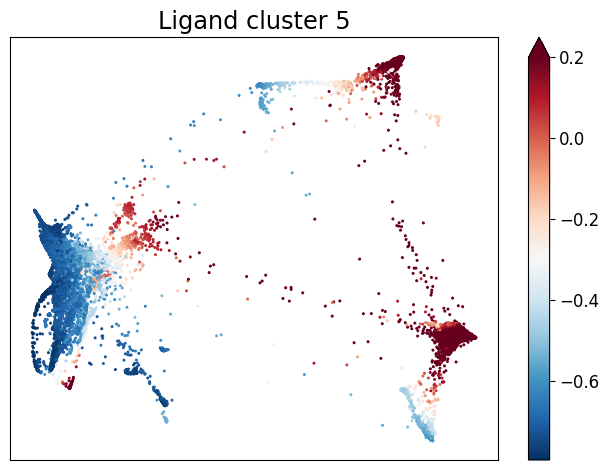

In [211]:
scprep.plot.scatter2d(adata.obsm['X_PHATE'], c=ligand_cluster_5, cmap='RdBu_r', vmax=0.2,
                     ticks=None, title='Ligand cluster 5', dpi=500, filename=f'./figures/ligand_cluster_5.png')

<Axes: title={'center': 'Receptor cluster 5'}>

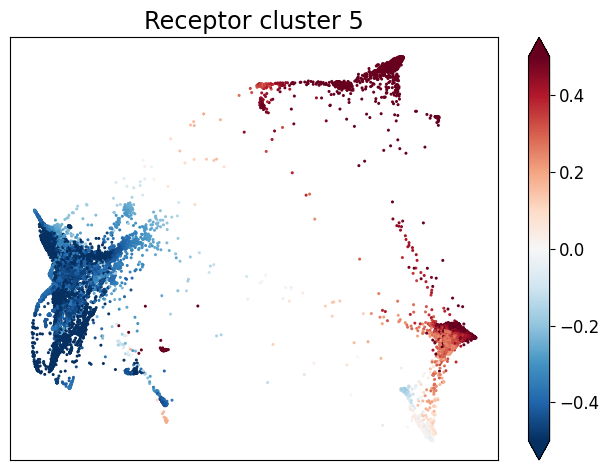

In [213]:
scprep.plot.scatter2d(adata.obsm['X_PHATE'], c=receptor_cluster_5, cmap='RdBu_r', vmax=0.5, vmin=-0.5,
                      ticks=None, title='Receptor cluster 5', dpi=500, filename=f'./figures/receptor_cluster_5.png')

In [196]:
ligand_cluster_19 = scale(data_magic[signaling_pathways_hvgs[signaling_pathways_hvgs['clusters'] == 19]['ligand']]).mean(axis=1)
receptor_cluster_19 = scale(data_magic[signaling_pathways_hvgs[signaling_pathways_hvgs['clusters'] == 19]['receptor']]).mean(axis=1)

<Axes: title={'center': 'Ligand cluster 19'}>

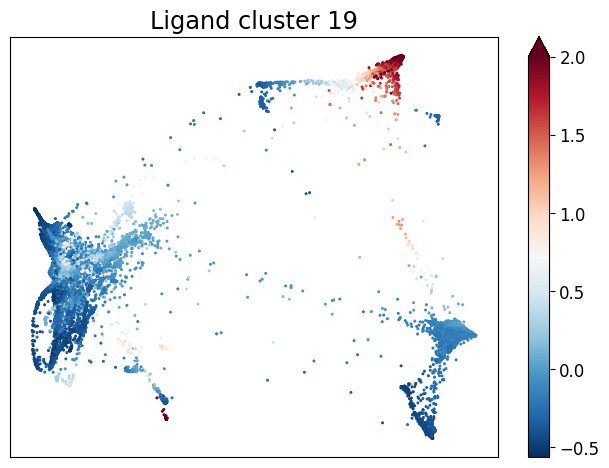

In [209]:
scprep.plot.scatter2d(adata.obsm['X_PHATE'], c=ligand_cluster_19, cmap='RdBu_r', vmax=2,
                      ticks=None, title='Ligand cluster 19', dpi=500, filename=f'./figures/ligand_cluster_19.png')

<Axes: title={'center': 'Receptor cluster 19'}>

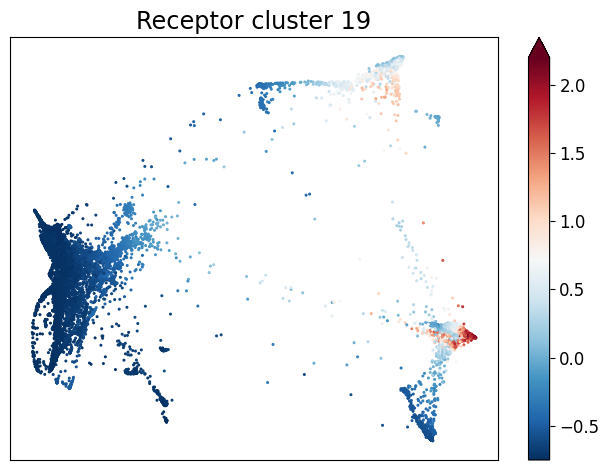

In [210]:
scprep.plot.scatter2d(adata.obsm['X_PHATE'], c=receptor_cluster_19, cmap='RdBu_r', vmax=2.2,
                      ticks=None, title='Receptor cluster 19', dpi=500, filename=f'./figures/receptor_cluster_19.png')

In [160]:
signaling_pathways_hvgs[signaling_pathways_hvgs['clusters'] == 5]['ligand'].unique()

array(['Ccl5', 'Ccl3', 'Ccl4', 'Ccl1', 'Csf1', 'Ifng', 'Fasl', 'Gzma',
       'Cd226', 'Itgb2', 'Selplg', 'Sema4a', 'Tigit'], dtype=object)

In [161]:
signaling_pathways_hvgs[signaling_pathways_hvgs['clusters'] == 5]['receptor'].unique()

array(['Ccr1', 'Ccr4', 'Ccr5', 'Ccr8', 'Ackr1', 'Csf1r', 'Ifngr1', 'Fas',
       'F2r', 'F2rl2', 'Pvr', 'Icam1', 'Icam2', 'Sell', 'Nrp1'],
      dtype=object)

## Learn pathway embedding

In [489]:
gspa_op = gspa.GSPA(graph=pair_phate_op.graph, qr_decompose=False)
gspa_op.build_diffusion_operator()
gspa_op.build_wavelet_dictionary()

In [493]:
pathway_indicator_signals = []
for pathway in np.unique(signaling_pathways_hvgs['pathway']):
    pathway_indicator_signals.append((signaling_pathways_hvgs['pathway'] == pathway).values.astype(int))
pathway_indicator_signals = np.array(pathway_indicator_signals)

In [ ]:
path_ae, path_pc = gspa_op.get_gene_embeddings(pathway_indicator_signals)

In [501]:
np.save('./results/pathway_embedding.npy', path_pc)

In [626]:
pathway_phate_op = phate.PHATE(random_state=42)
pathway_phate = pathway_phate_op.fit_transform(path_pc)

Calculating PHATE...
  Running PHATE on 93 observations and 93 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculating affinities...
  Calculating optimal t...
    Automatically selected t = 15
  Calculated optimal t in 0.01 seconds.
  Calculating diffusion potential...
  Calculating metric MDS...
Calculated PHATE in 0.04 seconds.


In [627]:
pathway_set = signaling_pathways_hvgs[['pathway', 'interaction']].drop_duplicates().set_index('pathway')
pathway_set = pathway_set.loc[~pathway_set.index.duplicated()]
pathway_set = pathway_set.loc[np.unique(signaling_pathways_hvgs['pathway'])]

In [628]:
pathways = ['PD-L1', 'PDL2', 'CXCL', 'CCL', 'NRG', 'CD39', 'OSM']

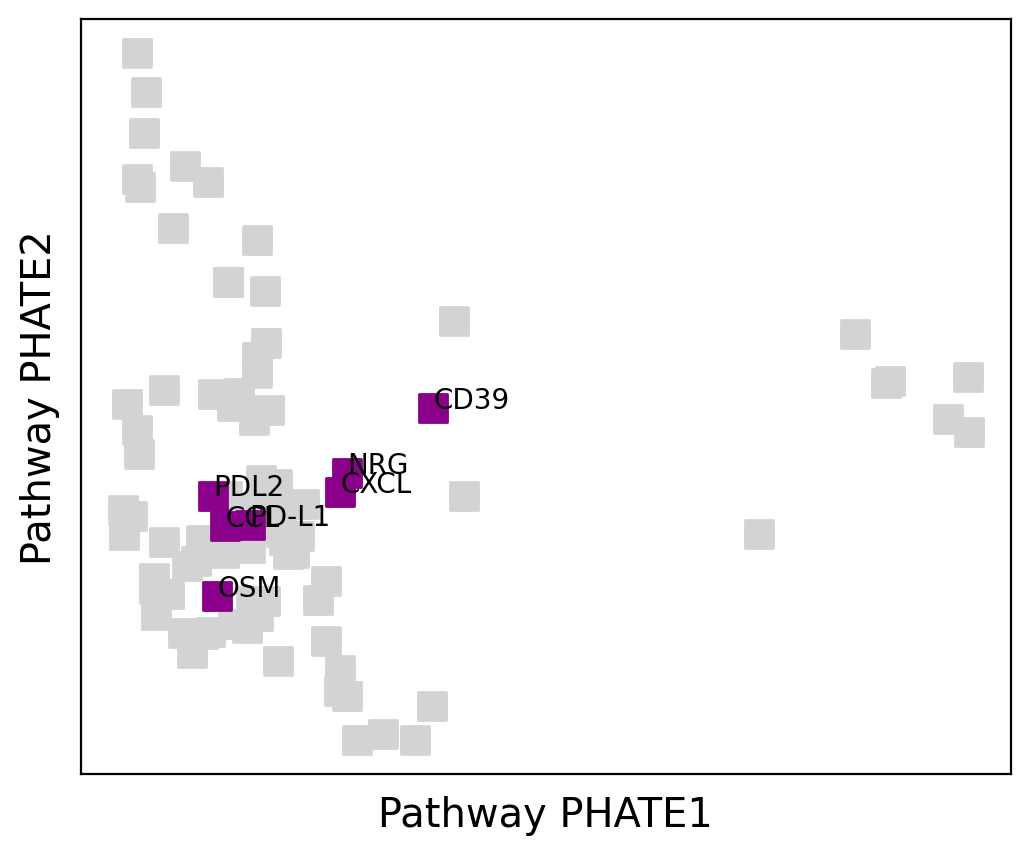

In [634]:
fig, ax = plt.subplots(figsize=(6,5), dpi=200)
scprep.plot.scatter2d(pathway_phate, c='lightgray',
                      ax=ax, ticks=None, marker='s', s=100)
scprep.plot.scatter2d(pathway_phate, marker='s', s=100, label_prefix="Pathway PHATE",
                      mask=pathway_set.index.isin(pathways), c='darkmagenta', ax=ax)

for i, name in enumerate(pathway_set.index):
    if name in pathways:
        ax.annotate(name, (pathway_phate[i, 0], pathway_phate[i, 1]))

fig.savefig('figures/pathway_phate.png', dpi=200)